# Imports

In [4]:
import torch as tc
import seaborn as sns
import pandas as pd
tcd = tc.distributions

# Data

<AxesSubplot:>

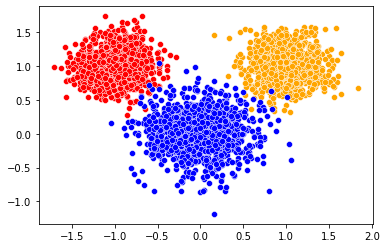

In [11]:
var_ear = 0.05
var_head = 0.1

left_ear = tcd.MultivariateNormal(tc.tensor([-1,1]).float(), var_ear * tc.eye(2))
right_ear = tcd.MultivariateNormal(tc.tensor([1,1]).float(), var_ear * tc.eye(2))
head = tcd.MultivariateNormal(tc.tensor([0,0]).float(), var_head * tc.eye(2))

N = 1000

a = left_ear.sample(tc.Size([N]))
b = right_ear.sample(tc.Size([N]))
c = head.sample(tc.Size([N]))
data = tc.cat((a, b, c))

sns.scatterplot(x=a[:,0], y=a[:,1], color="red")
sns.scatterplot(x=b[:,0], y=b[:,1], color="orange")
sns.scatterplot(x=c[:,0], y=c[:,1], color="blue")

# Initialization

In [13]:
def initialize(K):
    mu = tc.rand([K, 2]) * 2 - 1
    sigma = tc.rand([K, 2, 2])
    sigma = tc.matmul(sigma, tc.transpose(sigma, 1, 2))
    pi = tc.rand(K)
    pi = pi / tc.sum(pi)
    return sigma, mu, pi

# Expectation

In [36]:
def GMM(K, pi, mu, sigma, data):
    dis = []
    for i in range(K):
        dis.append(tcd.MultivariateNormal(loc=mu[i], covariance_matrix=sigma[i]))
    wyn = tc.zeros(len(data), K)
    for i in range(K):
        wyn[:,i] = dis[i].log_prob(data) + tc.log(pi[i])
    wyn = tc.exp(wyn)
    for i in range(len(data)):
        wyn[i,:] = wyn[i,:] / tc.sum(wyn[i,:])
    return wyn.T

# Maximalization

In [25]:
def maximalization(posterior, data):
    K = posterior.size(0)
    N = data.size(0)
    N_k = tc.sum(posterior, dim=1)
    N_k = N_k.view(K, 1, 1)

    pi = N_k / N_k.sum()

    mu = posterior[:, None] @ data[None,]
    mu = mu / N_k

    A = data - mu
    A = A[:, :, :, None].view(N * K, 2, 1) @ A[:, :, None, :].view(N * K, 1, 2)
    A = A.view(K, N, 2, 2)
    sigma = posterior[:, :, None, None] * A
    sigma = tc.sum(sigma, axis = 1) / N_k

    return sigma.squeeze(), mu.squeeze(), pi.squeeze()

# Final Clustering

In [26]:
def model(data, K, n_iter):
    sigma, mu, pi = initialize(K)
    posterior = GMM(K, pi, mu, sigma, data)
    for i in range(n_iter):
        sigma, mu, pi = maximalization(posterior, data)
        posterior = GMM(K, pi, mu, sigma, data)
    return posterior, sigma, mu, pi

In [37]:
posterior, sigma, mu, pi = model(data, 3, 100)

<AxesSubplot:>

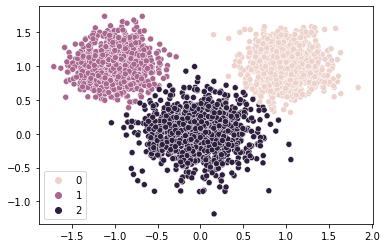

In [38]:
posterior_df = pd.DataFrame(posterior.T.numpy())
labels = posterior_df.idxmax(axis=1)

sns.scatterplot(x=data[:,0], y=data[:,1], hue=labels.values)